# TP 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import random

## Ejercicio 1

In [2]:
arrival_registers = []
with open(r'archivos/datosTP2EJ1.txt', 'r') as f:
    for line in f:
        arrival_registers.append(float(line))

#### Aplico un test de Algomorov-Smirnov para testear la media de los tiempos registrados

In [3]:
arrival_registers.sort()
mean_options = [180, 240]

for opt in mean_options:

    print("H0: mean={}, H1: mean!={}".format(opt, opt))
    s,p = st.kstest(arrival_registers , 'expon', args=(0,opt))

    significance=0.01

    if(p > significance):
        print("Acepto H0 con un pvalue de " + str(p) + " con un nivel de significancia de " + str(significance))
    else:
        print("No acepto H0")

H0: mean=180, H1: mean!=180
Acepto H0 con un pvalue de 0.5735940033913054 con un nivel de significancia de 0.01
H0: mean=240, H1: mean!=240
No acepto H0


Conclusion: Los tiempos registrados siguen una distribucion exponencial con media de 180 segundos

In [4]:
THOUSAND_DAYS = 1000
FULL_DAY = 24*60*60 # in seconds

In [5]:
class Witdrawer(object):
    
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(3, 50)

    def transaction_time(self):
        return np.random.exponential(scale=90)

In [6]:
class Depositor(object):

    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

    def amount(self):
        return np.random.randint(10,110)

    def transaction_time(self):
        return np.random.exponential(scale=500)

In [13]:
class ATM(object):

    MAXBILLS = 2000

    def __init__(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0
        self.totalTransactions = 0
        self.failedWithdrawers = 0
        self.transactionTimes = []
        self.bills = [self.MAXBILLS]

    def _processTime(self, client):
        waiting_time = 0
        transaction_time = client.transaction_time()
        if (client.arrival_time >= self._occupiedAtmTime):
            self._occupiedAtmTime = client.arrival_time + transaction_time

        elif (self._occupiedAtmTime > client.arrival_time):
            waiting_time = self._occupiedAtmTime - client.arrival_time
            self._occupiedAtmTime += transaction_time

        self.transactionTimes.append( transaction_time + waiting_time )

    def withdraw(self, withdrawerObj, trackBills = False):
        amount = withdrawerObj.amount()
        if (self._currentBills - amount) < 0:
            self.failedWithdrawers += 1  #Solo interesan failed withdrawers y no failed depositers?
        else:
            self._currentBills -= amount

        self.totalTransactions += 1
        self._processTime(withdrawerObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def deposit(self, depositorObj, trackBills = False):
        amount = depositorObj.amount()
        if (self._currentBills + amount) > self.MAXBILLS:
            pass 
        else:
            self._currentBills += amount

        self.totalTransactions += 1
        self._processTime(depositorObj)
        if trackBills:
            self.bills.append(self._currentBills)

    def reset(self):
        self._currentBills = self.MAXBILLS
        self._occupiedAtmTime = 0

In [8]:
types = ['withdrawer','withdrawer', 'withdrawer', 'depositor']

atm = ATM()
arrival_time = 0
random_day_to_track = np.random.randint(0,1000)
for i in range(THOUSAND_DAYS):
    arrival_time = 0
    trackBills = True if i == random_day_to_track else False
    while arrival_time < FULL_DAY:
        arrival_time += np.random.exponential(scale=180)
        clientType = random.choice(types)
        if clientType == 'withdrawer':
            withdrawer = Witdrawer(arrival_time)
            atm.withdraw(withdrawer, trackBills)

        else:
            depositor = Depositor(arrival_time)
            atm.deposit(depositor, trackBills)
    atm.reset()

In [9]:
num_transactions = len(atm.bills)
x = np.arange(0, num_transactions)

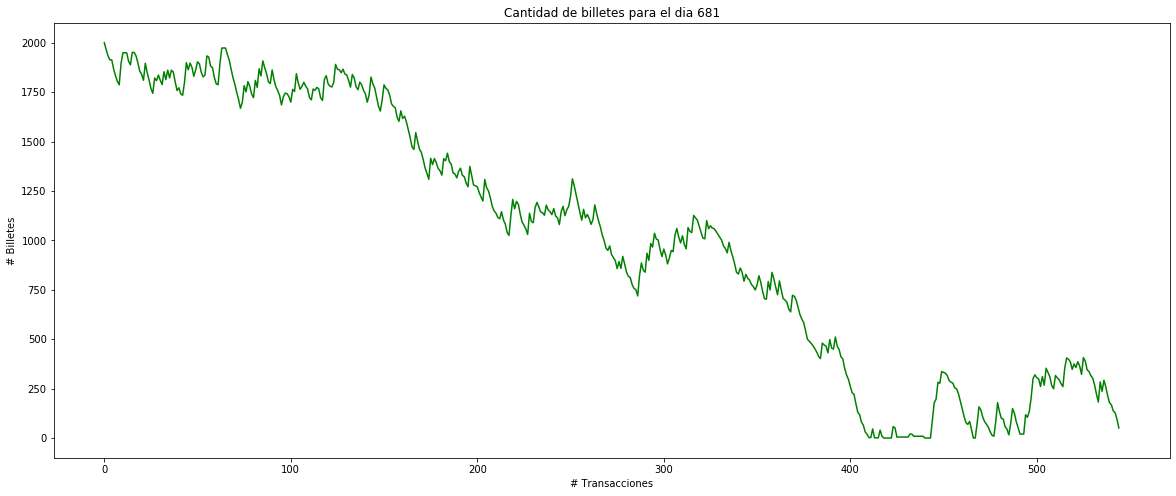

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylim((-100,2100)); ax.set_ylabel("# Billetes"); ax.set_xlabel("# Transacciones")
ax.set_title("Cantidad de billetes para el dia {}".format(random_day_to_track))
ax.plot(x, atm.bills, 'g')

In [11]:
print("Tiempo medio que los clientes demoraron en el sistema: {:.2f} segundos".format(np.mean(atm.transactionTimes)))

Tiempo medio que los clientes demoraron en el sistema: 5893.63 segundos


Tiempo medio de todos los clientes (tiempo de espera + tiempo usando el cajero)

In [12]:
failedTransactions = (atm.failedWithdrawers/atm.totalTransactions)*100
print("Porcentaje de clientes que se fueron sin retirar dinero: % {:.2f} ".format(failedTransactions))

Porcentaje de clientes que se fueron sin retirar dinero: % 4.65 


Como el porcentaje de clientes que se fueron sin retirar dinero es mucho menor a % 20 (porcentaje con el cajero actual) recomiendo a la empresa cambiar de cajero